# Task 1 - DeepLearning

In [1]:
!pip install -r requirements.txt

# **EDA**


In [2]:
#I am working in Google Colab and use Google Drive to store data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

In [4]:
#path to folders
#need to paste actual path

train_dir = '/content/drive/MyDrive/trainee_dataset/train'
test_dir = '/content/drive/MyDrive/trainee_dataset/test'

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness and contrast
    transforms.RandomRotation(10),  # Random rotation up to 10 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [6]:
class ArtifactDataset(Dataset):
    """
    Class for reading Dataset

    Features:
    - Reads .png images and parses labels from filenames
    - Supports different transformation strategies:
        * Class 0: full data augmentation
        * Class 1: basic resizing and normalization.
    - Prints the class distribution upon initialization for quick data sanity check.
    - Handles missing or unreadable image files by replacing them with a black placeholder image.

    Args:
        image_dir (str): Path to the directory containing image files.
        transform (callable, optional): Transformations to apply to class 0 samples.

    Returns:
        Tuple[Tensor, int]: Transformed image tensor and its corresponding label.
    """

    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for filename in os.listdir(image_dir):
            if filename.endswith(".png"):
                label = int(filename.split("_")[-1].split(".")[0])  # Extract label (0 or 1)
                img_path = os.path.join(image_dir, filename)
                self.images.append(img_path)
                self.labels.append(label)
        print(f"Class distribution: {np.bincount(self.labels)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Failed to load {img_path}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply augmentation only to class 0
        if self.transform and label == 0:
            image = self.transform(image)
        elif self.transform:
            # For class 1, apply basic transform without extra augmentation
            basic_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            image = basic_transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

Class distribution: [ 180 1620]


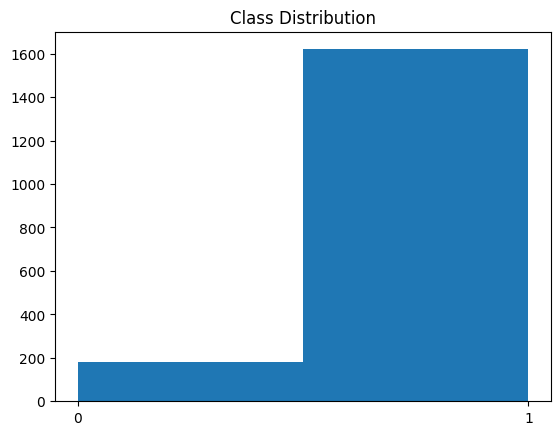

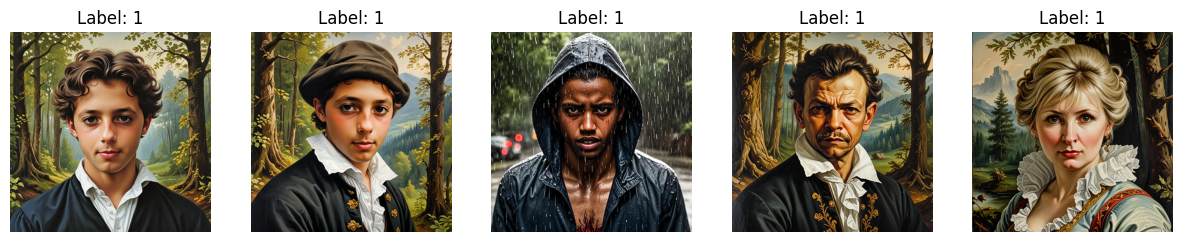

In [7]:
import matplotlib.pyplot as plt

# Example: Visualize class distribution
dataset = ArtifactDataset(train_dir)
labels = dataset.labels
plt.hist(labels, bins=2)
plt.xticks([0,1])
plt.title("Class Distribution")
plt.show()

# Example: Show sample images
fig, axs = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    img, label = dataset[i]
    axs[i].imshow(img.permute(1,2,0))  # convert from Tensor [C,H,W] to [H,W,C]
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
plt.show()

In [8]:
def get_data_loaders(train_dir, batch_size=32, val_size=0.2):
    """
    This function creates PyTorch DataLoaders for training and validation splits.

    Args:
        train_dir (str): Path to the directory containing the training images.
        batch_size (int, optional): Number of samples per batch. Defaults to 32.
        val_size (float, optional): Proportion of the dataset to be used as validation data. Defaults to 0.2.

    Returns:
        Tuple[DataLoader, DataLoader]:
            train_loader - DataLoader for training samples,
    """
    dataset = ArtifactDataset(train_dir, transform=transform)
    train_idx, val_idx = train_test_split(
        range(len(dataset)), test_size=val_size, stratify=dataset.labels
    )
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_idx)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_idx)
    return train_loader, val_loader

# **Model Selection and Training**

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

In [10]:
class ArtifactClassifier(nn.Module):
    """
    ArtifactClassifier is a custom image classification model based on a pre-trained ResNet-18 architecture.

    Args:
        num_classes (int): The number of output classes for classification. Our number is 2.

    Forward:
        x (torch.Tensor): Input tensor representing a batch of images.
        Returns:
            torch.Tensor: Raw output logits for each class.
    """

    def __init__(self, num_classes=2):
        super(ArtifactClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ArtifactClassifier().to(device)
print(f"Using device: {device}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu


In [11]:
def train_model(model, train_loader, val_loader, num_epochs=10, device="cuda"):
    """
    Trains the provided model.

    The function applies standard supervised learning with CrossEntropyLoss and the Adam optimizer.
    After each epoch, it evaluates the model using the micro-averaged F1 score on both training
    and validation datasets. If the validation F1 improves, the model's state is saved to disk.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        num_epochs (int): Number of training epochs. Default is 10.
        device (str): Device to use for training ('cuda' or 'cpu'). Default is 'cuda'.

    Returns:
        model (torch.nn.Module): The trained model (best state saved during training).
    """

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    model = model.to(device)
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} (Train)"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_f1 = f1_score(train_labels, train_preds, average="micro")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train F1: {train_f1:.4f}")

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_labels, val_preds, average="micro")
        print(f"Validation F1: {val_f1:.4f}")

        # Best model saving
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_artifact_classifier.pth")
            print("New best model saved!")

    return model

# **INFERENCE**

In [12]:
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_fscore_support

In [13]:
def infer(model, test_dir, device="cuda"):
    """
    Performs inference using the trained model on the test dataset.

    The function loads the test images from the given directory, makes predictions using the
    model, and calculates accuracy and class-wise metrics (Precision, Recall, and F1 score).
    It also ensures that the predicted and true labels are aligned in case of any discrepancies in their length.

    Args:
        model (torch.nn.Module): The trained model to be used for inference.
        test_dir (str): Directory containing the test images.
        device (str): The device for inference ('cuda' or 'cpu'). Default is 'cuda'.

    Returns:
        predictions (list): List of predicted class labels for the test images.
        true_labels (list): List of true class labels for the test images.

    Prints:
        - Accuracy: The percentage of correct predictions.
        - Class-wise metrics (Precision, Recall, F1 score) for both class 0 and class 1.
    """

    model.eval()
    test_dataset = ArtifactDataset(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32)
    predictions = []

    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc="Inference"):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

    true_labels = [int(f.split("_")[-1].split(".")[0]) for f in os.listdir(test_dir) if f.endswith(".png")]
    if len(predictions) != len(true_labels):
        min_length = min(len(predictions), len(true_labels))
        predictions = predictions[:min_length]
        true_labels = true_labels[:min_length]

    correct = sum(p == t for p, t in zip(predictions, true_labels))
    accuracy = (correct / len(true_labels)) * 100
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Number of correct predictions: {correct} out of {len(true_labels)}")

    # Class-wise metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None)
    print(f"Class 0 - Precision: {precision[0]:.2f}, Recall: {recall[0]:.2f}, F1: {f1[0]:.2f}")
    print(f"Class 1 - Precision: {precision[1]:.2f}, Recall: {recall[1]:.2f}, F1: {f1[1]:.2f}")

    return predictions, true_labels

# **Main**

In [14]:
# Load data
train_loader, val_loader = get_data_loaders(train_dir)

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

# Save the model
torch.save(trained_model.state_dict(), "artifact_classifier.pth")
print("Model saved as artifact_classifier.pth")

# Run inference on test set
test_predictions = infer(trained_model, test_dir, device)
#print("Test Predictions:", test_predictions)

# Calculate final micro F1 (if ground truth is available)
# Note: For the test set, you need labels to compute F1. If not provided, this is for validation only.

Class distribution: [ 180 1620]


Epoch 1 (Train):   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.1584, Train F1: 0.9444


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Validation F1: 0.9861
New best model saved!


Epoch 2 (Train):   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0435, Train F1: 0.9917


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Validation F1: 0.8306


Epoch 3 (Train):   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0377, Train F1: 0.9910


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Validation F1: 0.9917
New best model saved!


Epoch 4 (Train):   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0378, Train F1: 0.9896


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Validation F1: 0.9917


Epoch 5 (Train):   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0495, Train F1: 0.9889


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Validation F1: 0.9944
New best model saved!


Epoch 6 (Train):   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0292, Train F1: 0.9938


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Validation F1: 0.9944


Epoch 7 (Train):   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0154, Train F1: 0.9965


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Validation F1: 0.9861


Epoch 8 (Train):   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0230, Train F1: 0.9972


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Validation F1: 0.9917


Epoch 9 (Train):   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0335, Train F1: 0.9910


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Validation F1: 0.9889


Epoch 10 (Train):   0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0371, Train F1: 0.9889


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Validation F1: 0.9889
Model saved as artifact_classifier.pth
Class distribution: [ 20 180]


Inference:   0%|          | 0/7 [00:00<?, ?it/s]

Accuracy: 99.00%
Number of correct predictions: 198 out of 200
Class 0 - Precision: 1.00, Recall: 0.90, F1: 0.95
Class 1 - Precision: 0.99, Recall: 1.00, F1: 0.99
